# 0. Import packages

In [1]:
import firedrake
import numpy as np
import pickle as pkl
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, project, TransferManager
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle as pkl
import tqdm
import emcee
import corner
import itertools
import xarray
import dtscalibration
import glob
from rasterio.plot import show
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os
import sys
from pyproj import Transformer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scripts.AH_temp_funcs import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib widget

# 1. Load all the data we want

## 1.0 Load the DEMs, boreholes, basemap image, and GPS velocities

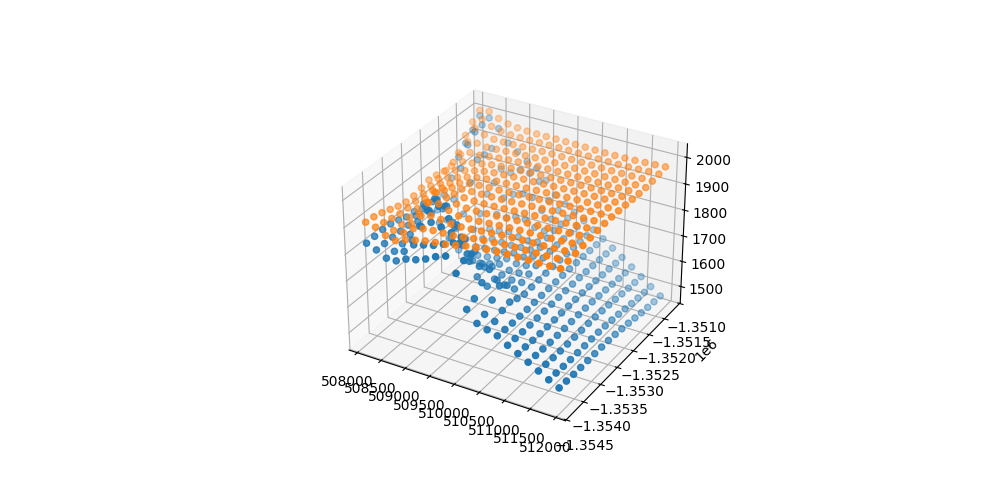

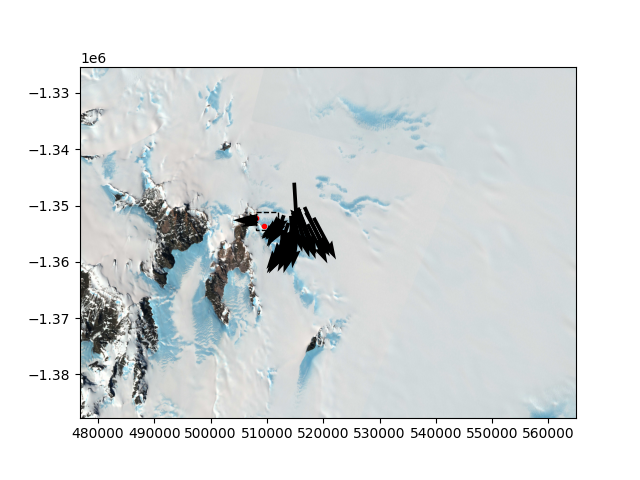

In [23]:
# Load tiff files of the DEMs

import rasterio
from rasterio.enums import Resampling

upscale_factor = 1/2

src_bed = rasterio.open("../Meshes/ThreeD_meshing/AH_bed_1902.tif")
bed_DEM = src_bed.read(1,
                        out_shape=(
                            src_bed.count,
                            int(src_bed.height * upscale_factor),
                            int(src_bed.width * upscale_factor)
                        ),
                        resampling=Resampling.bilinear
                    )

# scale image transform
src_bed_transform = src_bed.transform * src_bed.transform.scale(
    (src_bed.width / bed_DEM.shape[-1]),
    (src_bed.height / bed_DEM.shape[-2])
)

src_surf = rasterio.open("../Meshes/ThreeD_meshing/AH_surf_1902.tif")
surf_DEM = src_surf.read(1,
                        out_shape=(
                            src_surf.count,
                            int(src_surf.height * upscale_factor),
                            int(src_surf.width * upscale_factor)
                        ),
                        resampling=Resampling.bilinear
                    )

# scale image transform
src_surf_transform = src_surf.transform * src_surf.transform.scale(
    (src_surf.width / surf_DEM.shape[-1]),
    (src_surf.height / surf_DEM.shape[-2])
)

# surf_DEM[surf_DEM==0] = 2000 
# bed_DEM[bed_DEM==-1] = 1999
## Downsample the DEMs if desired
# downsample_factor = 20
# surf_DEM = surf_DEM[::downsample_factor, ::downsample_factor]
# bed_DEM = bed_DEM[::downsample_factor, ::downsample_factor]

height = surf_DEM.shape[0]
width = surf_DEM.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
xs, ys = rasterio.transform.xy(src_surf_transform, rows, cols)
lons= np.array(xs)
lats = np.array(ys)

surf_elevs = surf_DEM.flatten()
bed_elevs = bed_DEM.flatten()

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')

ax.scatter(lons, lats, bed_elevs)
ax.scatter(lons, lats, surf_elevs)

### Load boreholes
borehole_locations = pd.read_csv('../Borehole_Locations/Borehole_locations_DTS.csv')
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031", always_xy=True)
transformed_x, transformed_y = transformer.transform(borehole_locations['E'], borehole_locations['S'])

### Load image data

with rasterio.open('../imagery/LIMA_virtual_Mosaic_15m.tif') as src1:
    image_data = src1.read()

fig, ax = plt.subplots()
ax.scatter(transformed_x,transformed_y, marker='.',c='red', label='Boreholes')
show(image_data,ax=ax,transform=src1.transform)

width_m = src_surf_transform[0] *surf_DEM.shape[1]
height_m = src_surf_transform[4] *surf_DEM.shape[0]

ax.add_patch(plt.Rectangle((src_surf_transform[2], src_surf_transform[5]),width_m,height_m,  ls='--', ec='black',fc='None'))

### Load the GPS velocities
gps_velocities = pd.read_csv('../GPS_velocities/24-25_velocities-good.csv')

GPS_points = []
for i in gps_velocities.iloc():
    GPS_points.append([i['x'], i['y']])
ax.quiver(gps_velocities['x'], gps_velocities['y'], 
                gps_velocities['u'], gps_velocities['v'], 
                scale = None, label='GPS velocities')

## 1.1 Load the borehole temps

/tmp/ipykernel_3273236/4016192462.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


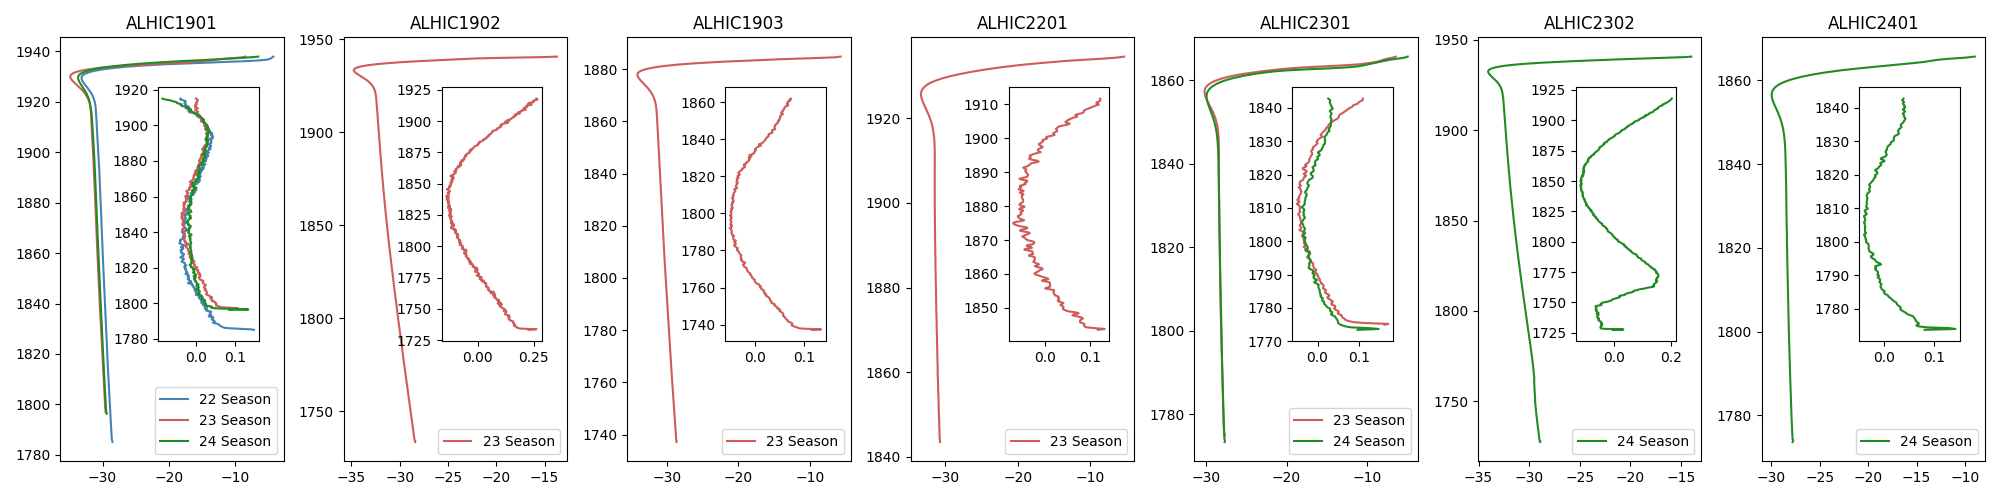

In [86]:
avg_temps = pd.read_pickle('../Borehole_Temps/avg_temps.pkl')
residual_temps = pd.read_pickle('../Borehole_Temps/residual_temps.pkl')

boreholes = ['ALHIC1901', 'ALHIC1902', 'ALHIC1903', 'ALHIC2201', 'ALHIC2301', 'ALHIC2302', 'ALHIC2401']

fig,axes = plt.subplots(1, len(boreholes), figsize=(20, 5))

insets = []
for ax in axes:
    axinses = inset_axes(ax, width = "100%", height = "100%", loc='lower right', bbox_to_anchor=(.5, .25, .45, .60), bbox_transform=ax.transAxes, borderpad=1)
    insets.append(axinses)


for i in avg_temps:
    for borehole, ax, axins in zip(boreholes, axes, insets):

        if i.startswith(borehole):
            if i[-2:] == '22':
                c = 'steelblue'
            elif i[-2:] == '23':
                c = 'indianred'
            elif i[-2:] == '24':
                c = 'forestgreen'
            ax.plot(avg_temps[i][2], avg_temps[i][0], label=i[-2:]+' Season',c=c)
            axins.plot(residual_temps[i][2], residual_temps[i][0], label=i[-2:]+' Season',c=c)
            ax.legend()

            ax.set_title(borehole)

plt.tight_layout()

# 2. Extrude the mesh

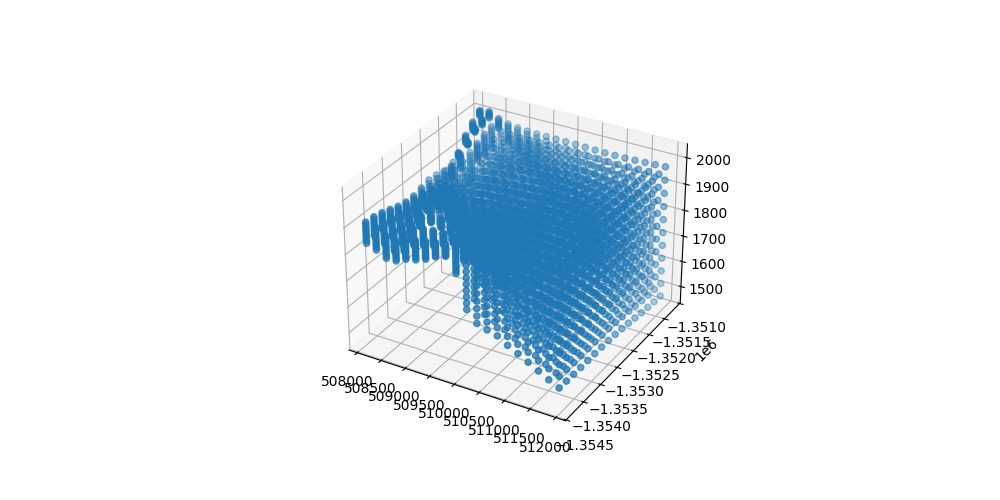

In [24]:
from firedrake import *
from firedrake.__future__ import interpolate

nx = width - 1
ny = height - 1

Lx = lons.max() # x extent, get this from the DEM
Ly = lats.max() # y extent, get this from the DEM

origin_x = lons.min() # origin (lower left corner) in x, get this from the DEM
origin_y = lats.min() # origin (lower left corner) in y, get this from the DEM

base_mesh = RectangleMesh(nx,ny, Lx, Ly, originX=origin_x, originY=origin_y)
# Make a height 1 mesh.
unit_extruded_mesh = ExtrudedMesh(base_mesh, layers=10)

base_fs = FunctionSpace(base_mesh, "CG", 1)

x,y, = SpatialCoordinate(base_mesh)

# You could set this field any way you like.
## Bed and surface DEM resolution should be nx+1, ny+1 as to match the coordinates of the mesh.

# Now we transfer the bathymetry field into a depth-averaged field.
extruded_element = FiniteElement("R", "interval", 0)
extruded_space = FunctionSpace(unit_extruded_mesh,
                                TensorProductElement(base_fs.ufl_element(),
                                                    extruded_element))


from scipy.interpolate import griddata
## interpolate the DEMs to the mesh coordinates so it is given in the mesh coordinate order
points = np.array([xs,ys]).T # DEM pixel coordinates
xi = base_mesh.coordinates.dat.data_ro[:,:2] # Get the mesh coordinates from the base mesh
surf_interp = griddata(points, surf_DEM.flatten(), xi, method='linear', fill_value=np.nan, rescale=False)
bed_interp = griddata(points, bed_DEM.flatten(), xi, method='linear', fill_value=np.nan, rescale=False)

## Extrude the bed and surface
extruded_bed = Function(extruded_space)
extruded_bed.dat.data_wo[:] = bed_interp

extruded_surface = Function(extruded_space)
extruded_surface.dat.data_wo[:] = surf_interp

# Build a new coordinate field by change of coordinates.
x, y, z = SpatialCoordinate(unit_extruded_mesh)
new_coordinates = assemble(
    interpolate(
        as_vector([x, y, extruded_bed + z * (1-extruded_bed) + z * extruded_surface]),
        unit_extruded_mesh.coordinates.function_space()
    )
)


# Finally build the mesh you are actually after.
mesh = Mesh(new_coordinates)


## Plot using scatter since we can't plot Tensor product using triplot
ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')

ax.scatter(mesh.coordinates.dat.data_ro[:,0], mesh.coordinates.dat.data_ro[:,1], mesh.coordinates.dat.data_ro[:,2])

# 3. Setup the FE model through firedrake

## 3.1 Define the functions and setup the momentum equation.

In [25]:
μ = Constant(5e15) #Ice


pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 3)
Y = velocity_space * pressure_space
flow = firedrake.Function(Y)
u, p = firedrake.split(flow)
v, q = firedrake.TestFunctions(flow.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, 0, grav))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

## 3.2 Define the boundary conditions

In [27]:
face_ids = ['top', 'bottom', 1, 2, 3, 4]

bc_stokes = []
for id in face_ids:
    if id == 'top': pass # Skip the top face (id 5) for now
    else:
        bc = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0, 0)), id) # No flow on the boundary
        bc_stokes.append(bc)

## 3.3 Solve the stokes problem

In [28]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, flow, bc_stokes)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}

stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

stokes_solver.solve()

## 3.4 Plot the results of the stokes solve

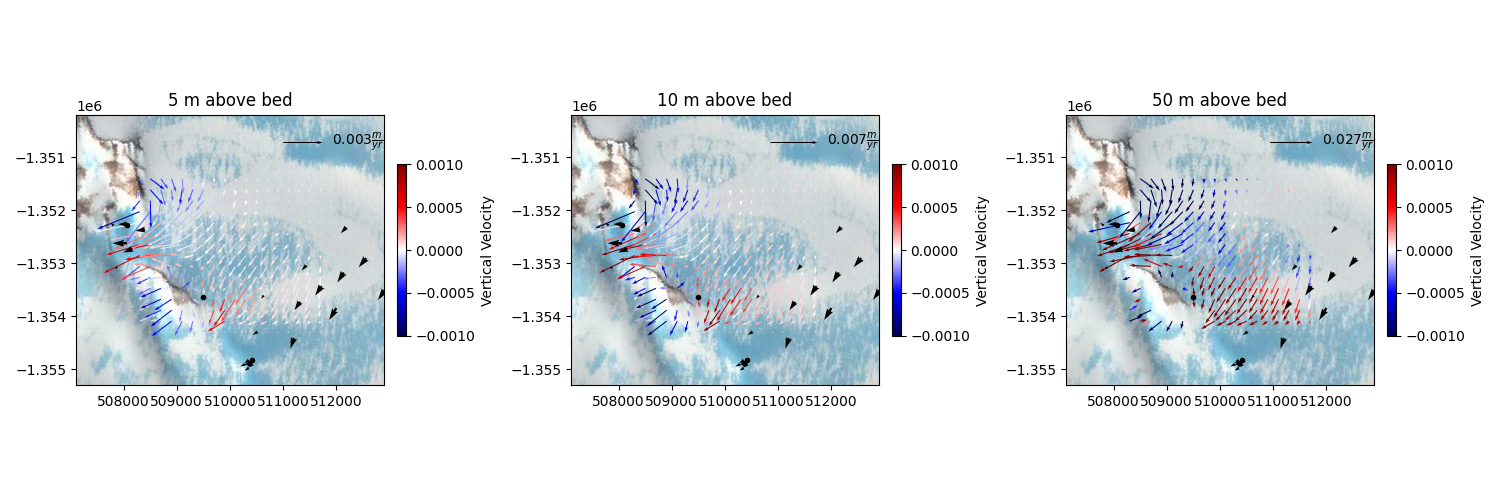

In [29]:


cross_sections = [5,10,50]

fig, axes = plt.subplots(1,len(cross_sections),figsize=[15,5])

for n,m_above_bed in enumerate(cross_sections):
    vel_cross = []
    vel_cross_coords = []

    ### If the DEM includes some nonesense pixels in it, you need this block ##########
    # for x_coord, y_coord, z_coord in zip(xi[:,0], xi[:,1], extruded_bed.dat.data_ro[:]):
    #     if 1998.99 < z_coord < 1999.01:
    #         continue
    #     else:
    #         vel_cross.append(y.at(x_coord, y_coord, z_coord+m_above_bed)[0])
    #         vel_cross_coords.append([x_coord, y_coord, z_coord+m_above_bed])
    #####################################################################################

    ### If the DEM is perfectly rectangular, than you can do this block ####
    for x_coord, y_coord, z_coord in zip(xi[:,0], xi[:,1], extruded_bed.dat.data_ro[:]):
        try:
            vel_cross.append(flow.at(x_coord, y_coord, z_coord+m_above_bed)[0])
            vel_cross_coords.append([x_coord, y_coord, z_coord+m_above_bed])
        except:
            continue

    #########################################


    vel_cross = np.asarray(vel_cross)
    vel_cross_coords = np.asarray(vel_cross_coords)

    norm = mcolors.Normalize(vmin=-0.001, vmax=0.001)
    cmap = plt.cm.seismic
    colors = cmap(norm(vel_cross[:,2]*spy))

    show(image_data,ax=axes[n],transform=src1.transform)
    Q = axes[n].quiver(vel_cross_coords[:,0], vel_cross_coords[:,1], vel_cross[:,0]*spy, vel_cross[:,1]*spy, scale = None, color=colors)

    axes[n].set_xlim([vel_cross_coords[:,0].min()-1000, vel_cross_coords[:,0].max()+1000])
    axes[n].set_ylim([vel_cross_coords[:,1].min()-1000, vel_cross_coords[:,1].max()+1000])

    axes[n].set_title(str(m_above_bed)+' m above bed')
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed only to satisfy colorbar creation
    cbar = plt.colorbar(sm, ax=axes[n], fraction=0.026, pad=0.04)
    cbar.set_label('Vertical Velocity')

    max_val = round(np.max(np.sqrt((vel_cross[:,0]*spy)**2+(vel_cross[:,1]*spy)**2)),3)
    axes[n].scatter(transformed_x,transformed_y, marker='.',c='black', label='Boreholes')
    max_val_str = str(max_val)
    qk = axes[n].quiverkey(Q, 0.8, 0.9, max_val, max_val_str+r'$\frac{m}{yr}$', labelpos='E', coordinates='axes', color='black')
    axes[n].quiver(gps_velocities['x'], gps_velocities['y'], 
                   gps_velocities['u'], gps_velocities['v'], 
                   scale = None, label='GPS velocities')
plt.tight_layout()
# plt.savefig('3d_flow_cross_sections_long.png', dpi=300)

# 4. Add temperature to this model

## 4.1 Setup the temp functions

In [30]:
from ufl import Measure
dx = ufl.Measure("dx", domain=mesh)

V = firedrake.FunctionSpace(mesh, "CG", 1)
# V = firedrake.FunctionSpace(mesh, extruded_element)

T = firedrake.Function(V)
ϕ = firedrake.TestFunction(V)

geo_flux = 0.05 # W/m^2 
k = Constant(2.22)  # W / m C

geothermal_flux = -geo_flux*ϕ  * ds_b
F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx

F = F_diffusion + F_advection + geothermal_flux

## 4.2 Define the boundary conditions

In [53]:
T_mean = -31 #average temp (C)

temperature_expr = T_mean - (z - 2000)*.01

surface_temp_bc = firedrake.DirichletBC(V, temperature_expr, 'top')

## 4.3 Solve for the temp field

In [54]:
firedrake.solve(F == 0, T, [surface_temp_bc])

## 4.4 Get the values at the boreholes

In [55]:
z_vals = mesh.coordinates.dat.data_ro[:,2]
depth_values = np.arange(z_vals.min(), z_vals.max(), 5)

temp_dict = {}

for x_bore, y_bore, name_bore in zip(transformed_x, transformed_y, borehole_locations['Core']):
    temp_coords = []
    temp_vals = []
    for z_bore in depth_values:
        try:
            temp = T.at(x_bore, y_bore, z_bore)
            temp_coords.append([x_bore, y_bore, z_bore])
            temp_vals.append(temp)
        except:
            continue
    temp_dict[name_bore] = [np.array(temp_vals), np.array(temp_coords)]

## 4.5 Plot the values at the boreholes

In [56]:
z_vals = mesh.coordinates.dat.data_ro[:,2]
depth_values = np.arange(z_vals.min(), z_vals.max(), 5)

In [57]:
temp_dict = {}

for x_bore, y_bore, name_bore in zip(transformed_x, transformed_y, borehole_locations['Core']):
    temp_coords = []
    temp_vals = []
    for z_bore in depth_values:
        try:
            temp = T.at(x_bore, y_bore, z_bore)
            temp_coords.append([x_bore, y_bore, z_bore])
            temp_vals.append(temp)
        except:
            continue
    if len(temp_vals) > 0:
        temp_dict[name_bore] = [np.array(temp_vals), np.array(temp_coords)]
    else: continue

## 4.6 Plot the modeled borehole temperatures

/tmp/ipykernel_3273236/574258.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


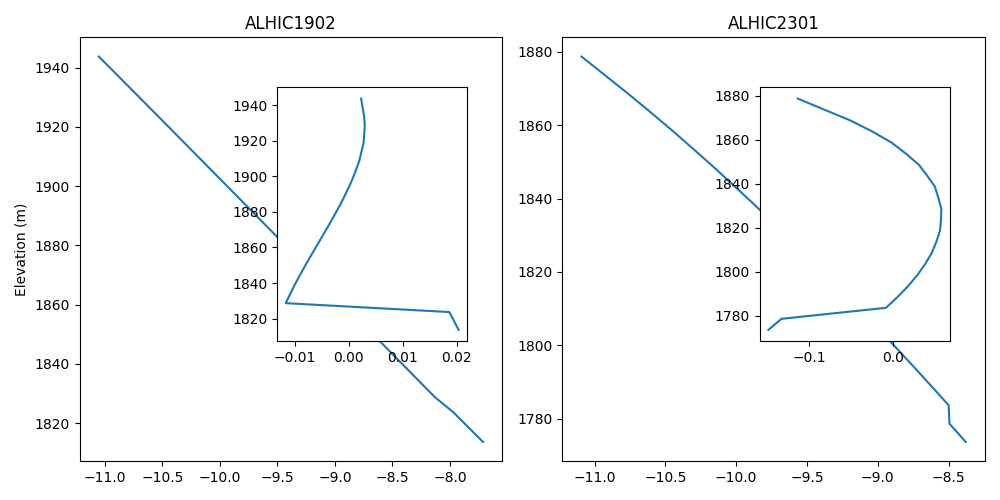

In [58]:
fig,axes = plt.subplots(1, len(temp_dict), figsize=[10,5])

for i, ax in zip(temp_dict, axes):
    ax.plot(temp_dict[i][0], temp_dict[i][1][:,2])
    ax.set_title(i)
    axinses = inset_axes(ax, width = "100%", height = "100%", loc='lower right', bbox_to_anchor=(.5, .25, .45, .60), bbox_transform=ax.transAxes, borderpad=1)
    axinses.plot(scipy.signal.detrend(temp_dict[i][0]), temp_dict[i][1][:,2])
axes[0].set_ylabel('Elevation (m)')
plt.tight_layout()

# 5. Update the viscosity so it is thermomechanically coupled

## 5.1 Viscosity updater script from the scripts folder

In [38]:
T_new,flow, stokes_solver = viscosity_updater_3d(x,z,ϕ,T,flow,u,V,[surface_temp_bc],mesh)

0.5860705619697043
0.022162806662083954
0.020790726768992303
0.017477568425523834
0.013569641154498933
0.009980730235558215


## 5.2 Plot the new flow/temperature coupled borehole temperatures

In [39]:
temp_dict = {}

for x_bore, y_bore, name_bore in zip(transformed_x, transformed_y, borehole_locations['Core']):
    temp_coords = []
    temp_vals = []
    for z_bore in depth_values:
        try:
            temp = T_new.at(x_bore, y_bore, z_bore)
            temp_coords.append([x_bore, y_bore, z_bore])
            temp_vals.append(temp)
        except:
            continue
    if len(temp_vals) > 0:
        temp_dict[name_bore] = [np.array(temp_vals), np.array(temp_coords)]
    else: continue

ALHIC1902
ALHIC2301


/tmp/ipykernel_3273236/748019206.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


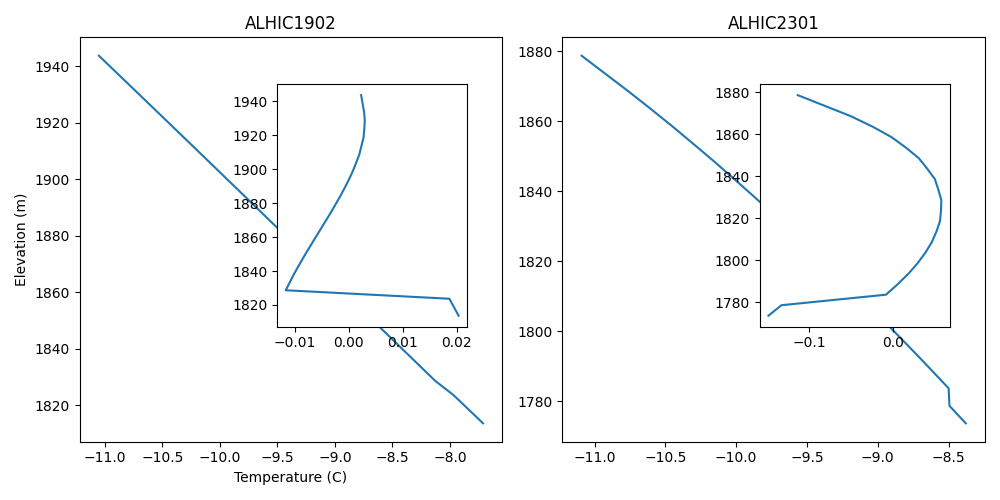

In [80]:
fig,axes = plt.subplots(1, len(temp_dict), figsize=[10,5])

for i, ax in zip(temp_dict, axes):
    ax.plot(temp_dict[i][0], temp_dict[i][1][:,2])
    ax.set_title(i)
    axinses = inset_axes(ax, width = "100%", height = "100%", loc='lower right', bbox_to_anchor=(.5, .25, .45, .60), bbox_transform=ax.transAxes, borderpad=1)
    axinses.plot(scipy.signal.detrend(temp_dict[i][0]), temp_dict[i][1][:,2])

    print(i)

axes[0].set_ylabel('Elevation (m)')
axes[0].set_xlabel('Temperature (C)')
plt.tight_layout()

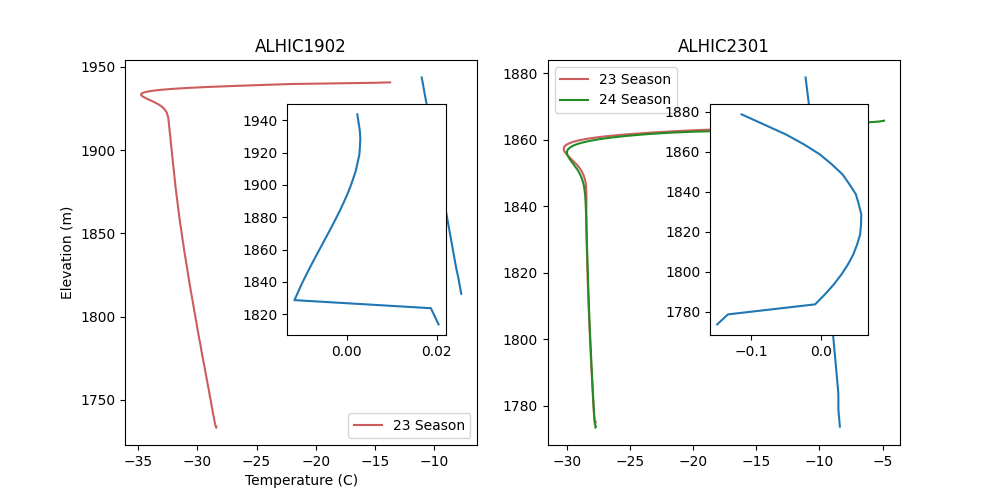

In [91]:
fig,axes = plt.subplots(1, len(temp_dict), figsize=[10,5])

for i, ax in zip(temp_dict, axes):
    ax.plot(temp_dict[i][0], temp_dict[i][1][:,2])
    ax.set_title(i)
    axinses = inset_axes(ax, width = "100%", height = "100%", loc='lower right', bbox_to_anchor=(.5, .25, .45, .60), bbox_transform=ax.transAxes, borderpad=1)
    axinses.plot(scipy.signal.detrend(temp_dict[i][0]), temp_dict[i][1][:,2])



axes[0].set_ylabel('Elevation (m)')
axes[0].set_xlabel('Temperature (C)')


for i in avg_temps:

    for name, ax in zip(temp_dict, axes):
        if i.startswith(name):
            if i[-2:] == '22':
                c = 'steelblue'
            elif i[-2:] == '23':
                c = 'indianred'
            elif i[-2:] == '24':
                c = 'forestgreen'
            ax.plot(avg_temps[i][2], avg_temps[i][0], label=i[-2:]+' Season',c=c)
            axins.plot(residual_temps[i][2], residual_temps[i][0], label=i[-2:]+' Season',c=c)
            ax.legend()
